<a href="https://colab.research.google.com/github/GDAC-miRNA/TCGA-hg19-hg38-QC/blob/master/TCGA_miRNA_QC_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCGA miRNA-seq QC: hg19 vs hg38 expression quantification

This Jupyter notebook is reproduces the miRNA-based analyses described in the publication **Before and After: A Comparison of Legacy and Harmonized**.  Specifically, we look in detail at the GRCh37/hg19 and GRCh38/hg38 miRNA expression quantification data from the NCI-GDC (Genomic Data Commons), making use of BigQuery tables hosted by the ISB-CGC (Cancer Genomics Cloud).

**NB**: There are two types of miRNA expression results: **isomiR** and **stemloop** quantification values.  The SQL queries and figures below will explore both of these types of expression quantification values.  More details about the GDC implementation of the BCGSC miRNA-Seq pipeline can be found [here](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/miRNA_Pipeline/).  The GRCh38/hg38, so-called "harmonized", data was generated by the GDC.  The original, GRCh37/hg19, so-called "legacy" data was generated by the BCGSC and details about that can be found in the 2016 *Nucleic Acids Resarch* publication by Chu *et al* titled ["Large-scale profiling of microRNAs for The Cancer Genome Atlas"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4705681/)

## Configuration and Setup  (IMPORTANT)
Most of the setup that happens in this section can be kept "hidden" when you run this notebook, with the exception of the *authentication* step below which will require that you sign in with Google and then **Allow** the Google Cloud SDK to access your Google account. You will then have to copy/paste a "verification code" (which looks something like ``KYuEQglK4/tACQe47cc_GZQa-KGm6JgJY8BiFyX0I27G-0cjnsz7Z6Fka``) into a box below.

After completing these steps, if you do *not* get a "successfully authenticated" message, you will *not* be able to continue running this notebook.  (Because of the nature of Jupyter notebooks, it is also possible that you may see the "successfully authenticated" message but it may have been from a previous, expired session, and you may need to re-authenticate)

### Import google.colab module
Our very first step is going to be to import the **google.colab** module which contains various useful methods, in particular **auth** and **files**.

Details regarding this module can be found on github under [googlecolab/colabtools](https://github.com/googlecolab/colabtools).


In [0]:
import google.colab as gc

### Authenticate with Google  (IMPORTANT)
Our first step is to authenticate with Google -- you will need to be a member of a Google Cloud Platform (GCP) project, with authorization to run BigQuery jobs in order to run this notebook.  If you don't have access to a GCP project, please contact the ISB-CGC team for help (www.isb-cgc.org)

In [2]:
try:
  gc.auth.authenticate_user()
  print('You have been successfully authenticated!')
except:
  print('You have not been authenticated.')

You have been successfully authenticated!


### Initialize connection to BigQuery  (IMPORTANT)
Once you're authenticated, we'll begin getting set up to pull data out of BigQuery.  

The first step is to initialize the BigQuery client.  This requires specifying a Google Cloud Platform (GCP) **project id** in which you have the necessary privileges (also referred to as "roles") to execute queries and access the data used by this notebook.

Below, we use a GCP project called ``isb-cgc-bq``.  If you have your own GCP project that you would like to use instead,  please **edit** the line below that sets the ``project_id`` variable *before* running the next cell.

In [3]:
from google.cloud import bigquery
try:
  project_id = 'isb-cgc-bq'
  bqclient = bigquery.Client(project=project_id)
  print('BigQuery client successfully initialized')
except:
  print('Failure to initialize BigQuery client')

BigQuery client successfully initialized


### Software Configuration

Unless any part of this section fails to run, you only need to look at this in detail if you are interested in understanding how this notebook works or in modifying it for your own purposes.  

Note that running this section alone will take about **5 minutes** due to the sizes of some of the libraries being imported, as well as the number of dependent libraries.  

Of course, once this section has been run, you will be able to run, modify, and re-run any of the later sections of this notebook without having to come back and rerun this section (as long as you have not lost your connection to the Jupyter server).

#### Import Python libraries

Import NumPy, Pandas, and seaborn

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

#### Python convenience functions

We define two convenience functions here:

- **`runQuery`**: a relatively generic BigQuery query-execution wrapper function which can be used to run a query in "dry-run"  mode or not:  the call to the `query()` function itself is inside a `try/except` block and if it fails we return `None`;  otherwise a "dry" run will return an empty dataframe, and a "live" run will return the query results as a dataframe

- **`checkQueryResults`**: a generic function that makes sure that what was returned is a dataframe, and checks how many rows are in the returned dataframe

In [0]:
def runQuery ( client, qString, dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )
 


def checkQueryResults ( qr ):
  print ( "\n in checkQueryResults ... " )
  if ( not isinstance(qr, pd.DataFrame) ):
    print ( " query execution failed! " )
    return ( False )
  else:
    if ( len(qr) > 0 ): 
      print ( " # of rows in query results: {} ".format(len(qr)) )
      print ( "\n", qr.head() )
    else:
      print ( " query returned NO results ?!? " )  
    return ( True )

#### Install RPy2 and select R packages

NB: Executing this next cell can take up to 5 minutes.  You may see several `RRuntimeWarning` messages, but they should only be warnings and should not actually cause any problems.

Documentation regarding using RPy2 for interactive work can be found [here](https://rpy2.readthedocs.io/en/version_2.8.x/interactive.html)



In [6]:
!apt-get -qq update
!apt-get -qq install r-base
!pip install -q rpy2 tzlocal

%load_ext rpy2.ipython

import rpy2
print("RPy2 version and build information:", rpy2.__version__, rpy2.rinterface.R_VERSION_BUILD)

# import rpy2's package module
import rpy2.robjects.packages as rp

RPy2 version and build information: 2.9.5 ('3', '6.0', '', 76424)


In [7]:
# import R's utility package
ru = rp.importr('utils')

# select a mirror for R packages
ru.chooseCRANmirror(ind=1) # select the first mirror in the list

# and install a few packages ...
ru.install_packages('dplyr')
ru.install_packages('tidyr')
ru.install_packages('ggplot2')
ru.install_packages('gridExtra')
ru.install_packages('ggrepel')
ru.install_packages('reshape2')

%R require("dplyr")
%R require("tidyr")
%R require("ggplot2")
%R require("gridExtra")
%R require("ggrepel")
%R require("reshape2")


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/dplyr_0.8.1.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1170671 bytes (1.1 MB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6

array([1], dtype=int32)

## BigQuery SQL query definitions
The next several cells contain SQL query definitions.  You do not need to "expand" this part of the notebook unless you want to examine the SQL queries in detail.

### Genome-wide Queries

In this sub-section, we define four different genome-wide queries.  The first two are used to take a close look, across *all of TCGA* at the correlation between hg19 and hg38 expression levels *vs* median expression, and the second pair just compute correlations, but with a few options (*eg* Pan-Cancer, or for a single specific tumor-type).

#### GW-Query #1: Correlation *vs* median(log(RPM)) Expression

This query computes the correlations (Pearson and Spearman) by using the *stemloop* tables.  Correlations are computed across all of the TCGA data *and* we simultaneously compute the median expression for each miRNA in both the **hg19** and **hg38** tables, so that we can compare the  median expression level for each miRNA in these two datasets.  Having the correlations in the same table allows us to test for a statistical association between the correlation coefficient(s) and the expression level(s).  

In [0]:
def build_GWquery01 ( ):
  
  qString = """
      WITH
        --
        -- we start with a table at the aliquot level, in case there are multiple aliquots
        -- for a single sample (returns ~21M row table)
        hg38_d1 AS (
        SELECT
          project_short_name,
          sample_barcode,
          aliquot_barcode,
          mirna_id,
          reads_per_million_miRNA_mapped AS sumRPM
        FROM
          `isb-cgc-04-0010.miRNA_QC.rel14_mirna_expression2` ),
        --
        -- next, in order to eliminate the aliquot_barcode field and get down
        -- to a single value per miR and per sample, we do a MAX() operation
        -- and while we're at it, we also perform a LOG (base-2) transform,
        -- and eliminate unobserved miRs (drops result down to ~7M rows)
        hg38_d2 AS (
        SELECT
          project_short_name AS project_id,
          sample_barcode,
          mirna_id,
          LOG(MAX(sumRPM)+1,2) AS logRPM
        FROM
          hg38_d1
        WHERE
          sumRPM > 0.01
        GROUP BY
          project_short_name,
          sample_barcode,
          mirna_id ),
        --
        -- in this step, we augment the previous table with a ranking of the logRPM
        -- expression values (no change in the # of rows, but one extra column)
        --
        -- the ranking is performed for each mirna_id, across the samples
        -- in which it was identified (result is still ~7M rows)
        hg38_d3 AS (
        SELECT
          project_id,
          sample_barcode,
          mirna_id,
          logRPM,
          DENSE_RANK() OVER(PARTITION BY mirna_id ORDER BY logRPM ASC) AS rankRPM
        FROM
          hg38_d2 ),
        --
        -- the final step in preparing the hg38 data is to calculate the overall
        -- median log-transformed expression value for each unique miRNA
        -- (obviously this is a very small table)
        hg38_d4 AS (
        SELECT
          DISTINCT mirna_id,
          PERCENTILE_CONT(logRPM,
            0.5) OVER(PARTITION BY mirna_id) AS medianLogRPM
        FROM
          hg38_d2 ),
        --
        -- now we repeat all of the above steps for the hg19 data
        --
        hg19_d1 AS (
        SELECT
          project_short_name,
          sample_barcode,
          aliquot_barcode,
          mirna_id,
          reads_per_million_miRNA_mapped AS sumRPM
        FROM
          `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Expression` ),
        hg19_d2 AS (
        SELECT
          project_short_name AS project_id,
          sample_barcode,
          mirna_id,
          LOG(MAX(sumRPM)+1,2) AS logRPM
        FROM
          hg19_d1
        WHERE
          sumRPM > 0.01
        GROUP BY
          project_short_name,
          sample_barcode,
          mirna_id ),
        hg19_d3 AS (
        SELECT
          project_id,
          sample_barcode,
          mirna_id,
          logRPM,
          DENSE_RANK() OVER(PARTITION BY mirna_id ORDER BY logRPM ASC) AS rankRPM
        FROM
          hg19_d2 ),
        hg19_d4 AS (
        SELECT
          DISTINCT mirna_id,
          PERCENTILE_CONT(logRPM,
            0.5) OVER(PARTITION BY mirna_id) AS medianLogRPM
        FROM
          hg19_d2 ),
        --
        -- now that we have the hg19 and hg38 data transformed as needed, we can join these
        -- two datasets to perform Pearson and Spearman (rank-based) correlations, and
        -- also find the difference between the median logRPM values for each mirna_id
        --
        -- first we will compute correlations using the "d3" tables, and then
        -- the difference in median expression values using the "d4" tables
        --
        -- for clarity, we break the process of computing correlations into two steps:
        -- first we perform the JOIN,
        -- and then we compute the CORR()
        --
        -- note that the result of the JOIN (the "j1" table) will have somewhat fewer
        -- rows than the input tables because we will only keep rows where each
        -- (sample_barcode, mirna_id) had a non-zero read-count
        -- in both the hg19 and the hg38 datasets
        --
        -- note also that in the correlation step, we count up the # of samples used
        -- in computing the correlation for each mirna_id and
        -- ignore those for which data is available from fewer than 20 samples
        -- (this throws out approximately 10% of the miRs, leaving us with ~2300 miRs)
        --
        j1 AS (
        SELECT
          a.logRPM AS hg19_logRPM,
          b.logRPM AS hg38_logRPM,
          ABS(b.logRPM - a.logRPM) AS absDelta_logRPM,
          a.rankRPM AS hg19_rankRPM,
          b.rankRPM AS hg38_rankRPM,
          b.project_id,
          b.sample_barcode,
          b.mirna_id
        FROM
          hg19_d3 a
        JOIN
          hg38_d3 b
        ON
          a.sample_barcode=b.sample_barcode
          AND a.mirna_id=b.mirna_id ),
        c1 AS (
        SELECT
          mirna_id,
          CORR(hg19_logRPM,
            hg38_logRPM) AS logCorr,
          CORR(hg19_rankRPM,
            hg38_rankRPM) AS rankCorr,
          COUNT(*) AS n
        FROM
          j1
        GROUP BY
          mirna_id
        HAVING
          n >= 20 ),
        d1 AS (
        SELECT
          a.mirna_id,
          a.medianLogRPM AS hg38_logMedian,
          b.medianLogRPM AS hg19_logMedian,
          (a.medianLogRPM - b.medianLogRPM) AS delta_logMedian
        FROM
          hg38_d4 a
        JOIN
          hg19_d4 b
        ON
          a.mirna_id=b.mirna_id ),
        d2 AS (
        SELECT
          DISTINCT mirna_id,
          PERCENTILE_CONT(absDelta_logRPM,
            0.5) OVER(PARTITION BY mirna_id) AS MAD_logRPM
        FROM
          j1 ),
        --
        -- let's join tables d1 and d2
        --
        d3 AS (
        SELECT
          d1.mirna_id,
          d1.hg38_logMedian,
          d1.hg19_logMedian,
          d1.delta_logMedian,
          d2.MAD_logRPM
        FROM
          d1
        JOIN
          d2
        ON
          d1.mirna_id = d2.mirna_id ),
        --
        -- we now create our "final" table by joining the correlations
        -- with the delta median expression values
        --
        final AS (
        SELECT
          b.mirna_id,
          a.logCorr,
          a.rankCorr,
          a.n,
          b.MAD_logRPM,
          b.delta_logMedian,
          b.hg19_logMedian,
          b.hg38_logMedian
        FROM
          c1 a
        JOIN
          d3 b
        ON
          a.mirna_id=b.mirna_id )
      SELECT
        *
      FROM
        final
      ORDER BY
        hg38_logMedian DESC,
        n DESC
  """
  
  ## print ( qString )
  return ( qString )    

#### GW-Query #2: Correlation *vs* median(log(RPM)) Expression

This query computes the correlations (Pearson and Spearman) for each *mature* miRNA (using the MIMAT identifiers), across all of the TCGA data *and* also computes the median expression for each miRNA in both the **hg19** and **hg38** tables, so that we can compare the  median expression level for each miRNA in these two datasets.  Having the correlations in the same table allows us to test for a statistical association between the correlation coefficient(s) and the expression level(s).  

In [0]:
def build_GWquery02 ( ):
  
  qString = """
      WITH
        --
        -- we start with a table at the aliquot level, in case there are multiple aliquots
        -- for a single sample (returns ~9M row table)
        hg38_d1 AS (
        SELECT
          project_short_name,
          sample_barcode,
          aliquot_barcode,
          mirna_accession,
          SUM(reads_per_million_miRNA_mapped) AS sumRPM
        FROM
          `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
        WHERE
          mirna_accession IS NOT NULL
        GROUP BY
          1,
          2,
          3,
          4 ),
        --
        -- next, in order to eliminate the aliquot_barcode field and get down
        -- to a single value per miR and per sample, we do a MAX() operation
        -- and while we're at it, we also perform a LOG (base-2) transform,
        -- and eliminate unobserved miRs (result is still ~9M rows)
        hg38_d2 AS (
        SELECT
          project_short_name AS project_id,
          sample_barcode,
          mirna_accession,
          LOG(MAX(sumRPM)+1,2) AS logRPM
        FROM
          hg38_d1
        WHERE
          sumRPM > 0.01
        GROUP BY
          project_short_name,
          sample_barcode,
          mirna_accession ),
        --
        -- in this step, we augment the previous table with a ranking of the logRPM
        -- expression values (no change in the # of rows, but one extra column)
        --
        -- the ranking is performed for each mirna_id, across the samples
        -- in which it was identified (result is still ~9M rows)
        hg38_d3 AS (
        SELECT
          project_id,
          sample_barcode,
          mirna_accession,
          logRPM,
          DENSE_RANK() OVER(PARTITION BY mirna_accession ORDER BY logRPM ASC) AS rankRPM
        FROM
          hg38_d2 ),
        --
        -- the final step in preparing the hg38 data is to calculate the overall
        -- median log-transformed expression value for each unique miRNA
        -- (obviously this is a very small table)
        hg38_d4 AS (
        SELECT
          DISTINCT mirna_accession,
          PERCENTILE_CONT(logRPM,
            0.5) OVER(PARTITION BY mirna_accession) AS medianLogRPM
        FROM
          hg38_d2 ),
        --
        -- now we repeat all of the above steps for the hg19 data
        --
        hg19_d1 AS (
        SELECT
          project_short_name,
          sample_barcode,
          aliquot_barcode,
          mirna_accession,
          SUM(reads_per_million_miRNA_mapped) AS sumRPM
        FROM
          `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Isoform_Expression`
        WHERE
          mirna_accession IS NOT NULL
        GROUP BY
          1,
          2,
          3,
          4 ),
        hg19_d2 AS (
        SELECT
          project_short_name AS project_id,
          sample_barcode,
          mirna_accession,
          LOG(MAX(sumRPM)+1,2) AS logRPM
        FROM
          hg19_d1
        WHERE
          sumRPM > 0.01
        GROUP BY
          project_short_name,
          sample_barcode,
          mirna_accession ),
        hg19_d3 AS (
        SELECT
          project_id,
          sample_barcode,
          mirna_accession,
          logRPM,
          DENSE_RANK() OVER(PARTITION BY mirna_accession ORDER BY logRPM ASC) AS rankRPM
        FROM
          hg19_d2 ),
        hg19_d4 AS (
        SELECT
          DISTINCT mirna_accession,
          PERCENTILE_CONT(logRPM,
            0.5) OVER(PARTITION BY mirna_accession) AS medianLogRPM
        FROM
          hg19_d2 ),
        --
        -- now that we have the hg19 and hg38 data transformed as needed, we can join these
        -- two datasets to perform Pearson and Spearman (rank-based) correlations, and
        -- also find the difference between the median logRPM values for each mirna_id
        --
        -- first we will compute correlations using the "d3" tables, and then
        -- the difference in median expression values using the "d4" tables
        --
        -- for clarity, we break the process of computing correlations into two steps:
        -- first we perform the JOIN,
        -- and then we compute the CORR()
        --
        -- note that the result of the JOIN (the "j1" table) will have somewhat fewer
        -- rows than the input tables because we will only keep rows where each
        -- (sample_barcode, mirna_id) had a non-zero read-count
        -- in both the hg19 and the hg38 datasets
        --
        -- note also that in the correlation step, we count up the # of samples used
        -- in computing the correlation for each mirna_id and
        -- ignore those for which data is available from fewer than 20 samples
        -- (this throws out approximately 10% of the miRs, leaving us with ~2300 miRs)
        --
        j1 AS (
        SELECT
          a.logRPM AS hg19_logRPM,
          b.logRPM AS hg38_logRPM,
          ABS(b.logRPM - a.logRPM) AS absDelta_logRPM,
          a.rankRPM AS hg19_rankRPM,
          b.rankRPM AS hg38_rankRPM,
          b.project_id,
          b.sample_barcode,
          b.mirna_accession
        FROM
          hg19_d3 a
        JOIN
          hg38_d3 b
        ON
          a.sample_barcode=b.sample_barcode
          AND a.mirna_accession=b.mirna_accession ),
        c1 AS (
        SELECT
          mirna_accession,
          CORR(hg19_logRPM,
            hg38_logRPM) AS logCorr,
          CORR(hg19_rankRPM,
            hg38_rankRPM) AS rankCorr,
          COUNT(*) AS n
        FROM
          j1
        GROUP BY
          mirna_accession
        HAVING
          n >= 20 ),
        d1 AS (
        SELECT
          a.mirna_accession,
          a.medianLogRPM AS hg38_logMedian,
          b.medianLogRPM AS hg19_logMedian,
          (a.medianLogRPM - b.medianLogRPM) AS delta_logMedian
        FROM
          hg38_d4 a
        JOIN
          hg19_d4 b
        ON
          a.mirna_accession=b.mirna_accession ),
        d2 AS (
        SELECT
          DISTINCT mirna_accession,
          PERCENTILE_CONT(absDelta_logRPM,
            0.5) OVER(PARTITION BY mirna_accession) AS MAD_logRPM
        FROM
          j1 ),
        --
        -- let's join tables d1 and d2
        --
        d3 AS (
        SELECT
          d1.mirna_accession,
          d1.hg38_logMedian,
          d1.hg19_logMedian,
          d1.delta_logMedian,
          d2.MAD_logRPM
        FROM
          d1
        JOIN
          d2
        ON
          d1.mirna_accession = d2.mirna_accession ),
        --
        -- we now create our "final" table by joining the correlations
        -- with the delta median expression values
        --
        final AS (
        SELECT
          b.mirna_accession,
          a.logCorr,
          a.rankCorr,
          a.n,
          b.MAD_logRPM,
          b.delta_logMedian,
          b.hg19_logMedian,
          b.hg38_logMedian
        FROM
          c1 a
        JOIN
          d3 b
        ON
          a.mirna_accession=b.mirna_accession )
      SELECT
        *
      FROM
        final
      ORDER BY
        hg38_logMedian DESC,
        n DESC
  """
  
  ## print ( qString )
  return ( qString )    
    

#### GW-Query #3: Computing correlations over the stem-loop expression tables

This query also uses BigQuery to compute both Pearson and Spearman correlations between the hg19 and hg38 expression values, but this time it can do so in one of three slightly different ways, depending on the value of the `study` parameter that is passed in to the function.

The `build_GWquery03` function will construct one of three slightly different queries, based on the value of the `study` parameter -- which can be either `PanCancer`, `All`, or a single TCGA study , *eg* `BRCA`.  The subtle distinction between `PanCancer` and `All` is that if `study=PanCancer` the analysis will perform a *single* analysis over *all* of the TCGA data, whereas if `study=All` the analysis will use *all* of the data, but results will be returned for *each* tumor-type (also sometimes referred to as a "TCGA study").

The full query is constructed in three parts:
*  in the first part (`qStrPartA`), the necessary data is extracted from the two miRNA stem-loop expression tables -- if the `study` parameter specifies a single study (*eg* `BRCA`), then we extract data only for that study, otherwise we extract data for all miRNA's listed in the `hg19_hg38_overlap` table;  after extracting the hg19 and hg38 data, we perform a JOIN operation in order to combine those data into a single interim table;
*  in the second part (`qStrPartB`), we rank the expression values;
*  in the third part (`qStrPartC`), we compute the Spearman and Pearson correlation coefficients 





In [0]:
def build_GWquery03 ( study ):
  
  ## complete list of TCGA study abbreviations
  studyList = [ 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 
                'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 
                'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 
                'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM' ]
  
  ## make sure that 'study' parameter is a valid string !!!
  if ( study=='PanCancer' or study=='All' or study in studyList ):
    pass
  else:
    print ( "ERROR: invalid input study string" )
    return ( null )
  
  ## If we are interested in a single study (eg BRCA), then the first part
  ## of this query will extract only the data for that study; otherwise we
  ## need the miRNA quantification values for *all* studies:
  
  if ( study=='PanCancer' or study=='All' ):
    qStrPartA = """
      WITH
        --
        -- first, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #1
        --
        ds1 AS (
          SELECT
            project_short_name, aliquot_barcode, mirna_id,
            LOG(reads_per_million_miRNA_mapped+1,2) AS logRPM
          FROM 
            `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Expression`
          WHERE
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) ),
        --
        -- next, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #2
        --
        ds2 AS (
          SELECT
            project_short_name, aliquot_barcode, mirna_id,
            LOG(reads_per_million_miRNA_mapped+1,2) AS logRPM
          FROM
            `isb-cgc-04-0010.miRNA_QC.rel14_mirna_expression2`
          WHERE
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) ),
        --
        -- next, join the two sets of RPM values on the aliquot and miRNA
        --
        j1 AS (
          SELECT
            ds1.project_short_name AS Study,
            ds1.mirna_id AS miRNA_ID,
            ds1.logRPM AS ds1_logRPM,
            ds2.logRPM AS ds2_logRPM
          FROM ds1
          JOIN ds2
          ON ds1.aliquot_barcode = ds2.aliquot_barcode 
             AND ds1.mirna_id = ds2.mirna_id ),
    """
  elif ( study in studyList ):
     qStrPartA = """
      WITH
        --
        -- first, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #1
        --
        ds1 AS (
          SELECT
            project_short_name, aliquot_barcode, mirna_id,
            LOG(reads_per_million_miRNA_mapped+1,2) AS logRPM
          FROM 
            `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Expression`
          WHERE
            SUBSTR(project_short_name,6) = '{study}' AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) ),
        --
        -- next, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #2
        --
        ds2 AS (
          SELECT
            project_short_name, aliquot_barcode, mirna_id,
            LOG(reads_per_million_miRNA_mapped+1,2) AS logRPM
          FROM
            `isb-cgc-04-0010.miRNA_QC.rel14_mirna_expression2`
          WHERE
            SUBSTR(project_short_name,6) = '{study}' AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) ),
        --
        -- next, join the two sets of RPM values on the aliquot and miRNA
        --
        j1 AS (
          SELECT
            ds1.project_short_name AS Study,
            ds1.mirna_id AS miRNA_ID,
            ds1.logRPM AS ds1_logRPM,
            ds2.logRPM AS ds2_logRPM
          FROM ds1
          JOIN ds2
          ON ds1.aliquot_barcode = ds2.aliquot_barcode 
             AND ds1.mirna_id = ds2.mirna_id ),
     """.format(study=study)
  
  ## In this next part of the query, we generate the rankings that will be required 
  ## to compute the Spearman correlation.  How these rankings are generated will
  ## depend on the value of the `study` parameter
  
  if ( study=='PanCancer'):
    qStrPartB = """
      r1 AS (
        SELECT
          miRNA_ID, ds1_logRPM, ds2_logRPM,
          DENSE_RANK() OVER(PARTITION BY miRNA_ID ORDER BY ds1_logRPM ASC) AS ds1_rpmRank,
          DENSE_RANK() OVER(PARTITION BY miRNA_ID ORDER BY ds2_logRPM ASC) AS ds2_rpmRank
        FROM j1 )
    """
  elif ( study=='All' or study in studyList ):
    qStrPartB = """
      r1 AS (
        SELECT
          Study, miRNA_ID, ds1_logRPM, ds2_logRPM,
          DENSE_RANK() OVER(PARTITION BY Study, miRNA_ID ORDER BY ds1_logRPM ASC) AS ds1_rpmRank,
          DENSE_RANK() OVER(PARTITION BY Study, miRNA_ID ORDER BY ds2_logRPM ASC) AS ds2_rpmRank
        FROM j1 )
    """
  
  ## And, similarly, exactly how the correlations are calculated will also
  ## depend on the value of the `study` parameter
  
  if ( study=='PanCancer' ):
    qStrPartC = """
      SELECT
        miRNA_ID, COUNT(*) AS N,
        CORR(ds1_logRPM,ds2_logRPM) AS pearson,
        CORR(ds1_rpmRank,ds2_rpmRank) AS spearman
      FROM r1
      GROUP BY miRNA_ID
      HAVING spearman IS NOT NULL OR pearson IS NOT NULL
    """
  elif ( study=='All' or study in studyList ):
    qStrPartC = """
      SELECT
        miRNA_ID, Study, COUNT(*) AS N,
        CORR(ds1_logRPM,ds2_logRPM) AS pearson,
        CORR(ds1_rpmRank,ds2_rpmRank) AS spearman
      FROM r1
      GROUP BY miRNA_ID, Study
      HAVING spearman IS NOT NULL OR pearson IS NOT NULL
    """

  ## Finally, we construct the complete query
  qString = qStrPartA + qStrPartB + qStrPartC 
  
  ## print ( qString )
  return ( qString )

#### GW-Query #4: Computing correlations over the isomiR expression tables

This query is essentially identical to **GW-Query #3** with the exception that the data originates from the isomiR tables rather than the stem-loop tables. 

In [0]:
def build_GWquery04 ( study ):
  
  ## complete list of TCGA study abbreviations
  studyList = [ 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 
                'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 
                'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 
                'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM' ]
  
  ## make sure that 'study' parameter is a valid string !!!
  if ( study=='PanCancer' or study=='All' or study in studyList ):
    pass
  else:
    print ( "ERROR: invalid input study string" )
    return ( null )
  
  ## If we are interested in a single study (eg BRCA), then the first part
  ## of this query will extract only the data for that study; otherwise we
  ## need the miRNA quantification values for *all* studies:
  
  if ( study=='PanCancer' or study=='All' ):
    qStrPartA = """
      WITH
        --
        -- first, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #1
        --
        ds1 AS (
          SELECT
            project_short_name, aliquot_barcode, 
            mirna_accession, mirna_transcript,
            SUM(reads_per_million_miRNA_mapped) AS sumRPM
          FROM 
            `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Isoform_Expression`
          WHERE
            mirna_accession IS NOT null AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` )
          GROUP BY
            project_short_name, aliquot_barcode,  
            mirna_accession, mirna_transcript ),
        --
        -- next, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #2
        --
        ds2 AS (
          SELECT
            project_short_name, aliquot_barcode,
            mirna_accession, mirna_transcript,
            SUM(reads_per_million_miRNA_mapped) AS sumRPM
          FROM
            `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
          WHERE
            mirna_accession IS NOT null AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) 
          GROUP BY
            project_short_name, aliquot_barcode,  
            mirna_accession, mirna_transcript ),
        --
        -- next, join the two sets of RPM values on the aliquot and miRNA
        --
        j1 AS (
          SELECT
            ds1.project_short_name AS Study,
            ds1.mirna_accession as miRNA_accession,
            ds1.mirna_transcript AS miRNA_transcript,
            LOG(ds1.sumRPM+1,2) AS ds1_logSumRPM,
            LOG(ds2.sumRPM+1,2) AS ds2_logSumRPM
          FROM ds1
          JOIN ds2
          ON ds1.aliquot_barcode = ds2.aliquot_barcode 
             AND ds1.mirna_accession = ds2.mirna_accession
             AND ds1.mirna_transcript = ds2.mirna_transcript ),
    """
  elif ( study in studyList ):
     qStrPartA = """
      WITH
        --
        -- first, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #1
        --
        ds1 AS (
          SELECT
            project_short_name, aliquot_barcode, 
            mirna_accession, mirna_transcript,
            SUM(reads_per_million_miRNA_mapped) AS sumRPM
          FROM 
            `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Isoform_Expression`
          WHERE
            SUBSTR(project_short_name,6) = '{study}' AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` ) 
          GROUP BY
            project_short_name, aliquot_barcode,  
            mirna_accession, mirna_transcript ),
        --
        -- next, pull out the RPM values for ALL miRNAs that are
        -- in the "overlap" list from Table #2
        --
        ds2 AS (
          SELECT
            project_short_name, aliquot_barcode, 
            mirna_accession, mirna_transcript,
            SUM(reads_per_million_miRNA_mapped) AS sumRPM
          FROM
            `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
          WHERE
            SUBSTR(project_short_name,6) = '{study}' AND
            mirna_id IN ( SELECT * FROM `isb-cgc-04-0010.reference_data.hg19_hg38_overlap` )
          GROUP BY
            project_short_name, aliquot_barcode,  
            mirna_accession, mirna_transcript ),
        --
        -- next, join the two sets of RPM values on the aliquot and miRNA
        --
        j1 AS (
          SELECT
            ds1.project_short_name AS Study,
            ds1.mirna_accession as miRNA_accession,
            ds1.mirna_transcript AS miRNA_transcript,
            LOG(ds1.sumRPM+1,2) AS ds1_logSumRPM,
            LOG(ds2.sumRPM+1,2) AS ds2_logSumRPM
          FROM ds1
          JOIN ds2
          ON ds1.aliquot_barcode = ds2.aliquot_barcode 
             AND ds1.mirna_accession = ds2.mirna_accession
             AND ds1.mirna_transcript = ds2.mirna_transcript ),
     """.format(study=study)
  
  ## In this next part of the query, we generate the rankings that will be required 
  ## to compute the Spearman correlation.  How these rankings are generated will
  ## depend on the value of the `study` parameter
  
  if ( study=='PanCancer'):
    qStrPartB = """
      r1 AS (
        SELECT
          mirna_accession, ds1_logSumRPM, ds2_logSumRPM,
          DENSE_RANK() OVER(PARTITION BY miRNA_accession ORDER BY ds1_logSumRPM ASC) AS ds1_logRPMrank,
          DENSE_RANK() OVER(PARTITION BY miRNA_accession ORDER BY ds2_logSumRPM ASC) AS ds2_logRPMrank
        FROM j1 )
    """
  elif ( study=='All' or study in studyList ):
    qStrPartB = """
      r1 AS (
        SELECT
          Study, mirna_accession, ds1_logSumRPM, ds2_logSumRPM,
          DENSE_RANK() OVER(PARTITION BY Study, miRNA_accession ORDER BY ds1_logSumRPM ASC) AS ds1_logRPMrank,
          DENSE_RANK() OVER(PARTITION BY Study, miRNA_accession ORDER BY ds2_logSumRPM ASC) AS ds2_logRPMrank
        FROM j1 )
    """
  
  ## And, similarly, exactly how the correlations are calculated will also
  ## depend on the value of the `study` parameter
  
  if ( study=='PanCancer' ):
    qStrPartC = """
      SELECT
        mirna_accession, COUNT(*) AS N,
        CORR(ds1_logSumRPM,ds2_logSumRPM) AS pearson,
        CORR(ds1_logRPMrank,ds2_logRPMrank) AS spearman
      FROM r1
      GROUP BY mirna_accession
      HAVING spearman IS NOT NULL OR pearson IS NOT NULL
    """
  elif ( study=='All' or study in studyList ):
    qStrPartC = """
      SELECT
        mirna_accession, Study, COUNT(*) AS N,
        CORR(ds1_logSumRPM,ds2_logSumRPM) AS pearson,
        CORR(ds1_logRPMrank,ds2_logRPMrank) AS spearman
      FROM r1
      GROUP BY mirna_accession, Study
      HAVING spearman IS NOT NULL OR pearson IS NOT NULL
    """

  ## Finally, we construct the complete query
  qString = qStrPartA + qStrPartB + qStrPartC 
  
  ## print ( qString )
  return ( qString )

#### GW-Query #5: All mature miRNAs, within Tumor-Types 

This query is somewhat similar to the previous one, and generates a table with over 17,000 rows -- in which each row represents a specific tumor type (*eg* `TCGA-SKCM`) and a specific mature miRNA, identified using both the MIMAT # (*eg* `MIMAT0004975`) and the mature product symbol (*eg* `hsa-miR-509-3-5p`).  The additional information describing this mature miRNA within this tumor type includes:

*   both Pearson and Spearman correlation coefficients
*   the number of samples used to compute the correlations (`nCorr`)
*   the number of samples with **zero** observed reads aligned to this specific miRNA (`hg19_nZero` and `hg38_nZero`), as well as the difference between these two counts (`delta_nZero`)
*   the average of the $log_2(RPM)$ vectors used to compute the Pearson correlation, from each dataste (`hg19avgLogRPM` and `hg38avgLogRPM`), as well as the difference between the two (`avgDelta`)

**NB**: this query is not currently being used elsewhere in this notebook, but is included here in case someone is interested in doing this type of analysis.



In [0]:
def build_GWquery05 ( ):
  
  qString = """
      WITH
        --
        -- we start by creating a dummy table with zero RPM for all sample barcodes
        -- and all mature miRNAs (identified using MIMAT # and mature product symbol)
        -- we do this by creating two separate tables (dummy1 and dummy2) and then
        -- the final table ("zt") is the CROSS JOIN of the first two ...
        dummy1 AS (
        SELECT DISTINCT
          product_accession AS mirna_accession,
          product_symbol AS mirna_symbol,
          0 AS zeroRPM
        FROM
          `isb-cgc.genome_reference.miRBase_v22_high_conf`
        WHERE
          taxonomic_abbrev="HSA" ),
        dummy2 AS (
        SELECT
          project_short_name AS project_name,
          sample_barcode
        FROM
          `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
        GROUP BY
          1, 2 ),
        zt AS (
        SELECT
          mirna_accession,
          mirna_symbol,
          zeroRPM,
          project_name,
          sample_barcode
        FROM
          dummy1
        CROSS JOIN
          dummy2 ),
        --
        -- now that we have the dummy "zt" table which we will use to "fill in"
        -- zero RPM values for the unobserved mature miRNAs, we can start working
        -- with real data ... for each of the two datasets (hg19 and hg38), this
        -- will be a 3 step process:
        --       (a) sum the RPMs for all mature miRs, for each aliquot
        --       (b) for cases where there are multiple aliquots per sample, keep the MAX value frome one aliquot
        --       (c) performa RIGHT JOIN with the "zt" table and use COALESCE to fill in 0s for unobserved miRs
        -- first we will get the hg19 data
        ds1a AS (
        SELECT
          project_short_name AS project_name,
          sample_barcode,
          aliquot_barcode,
          mirna_accession,
          SUM(reads_per_million_miRNA_mapped) AS sumRPM
        FROM
          `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Isoform_Expression`
        WHERE
          mirna_transcript="mature"
          AND mirna_accession IN (
          SELECT DISTINCT
            product_accession AS mirna_accession
        FROM
          `isb-cgc.genome_reference.miRBase_v22_high_conf`
        WHERE
          taxonomic_abbrev="HSA" )
        GROUP BY
          1, 2, 3, 4 ),
        ds1b AS (
        SELECT
          project_name,
          sample_barcode,
          mirna_accession,
          MAX(sumRPM) AS sumRPM
        FROM
          ds1a
        GROUP BY
          1, 2, 3 ),
        ds1c AS (
        SELECT
          COALESCE(b.project_name,
            a.project_name) AS project_name,
          COALESCE(b.sample_barcode,
            a.sample_barcode) AS sample_barcode,
          COALESCE(b.mirna_accession,
            a.mirna_accession) AS mirna_accession,
          b.mirna_symbol,
          COALESCE(a.sumRPM,
            b.zeroRPM) AS sumRPM
        FROM
          ds1b a
        RIGHT JOIN
          zt b
        ON
          a.mirna_accession=b.mirna_accession
          AND a.sample_barcode=b.sample_barcode ),
        --
        -- and then the hg38 data:
        ds2a AS (
        SELECT
          project_short_name AS project_name,
          sample_barcode,
          aliquot_barcode,
          mirna_accession,
          SUM(reads_per_million_miRNA_mapped) AS sumRPM
        FROM
          `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
        WHERE
          mirna_transcript="mature"
          AND mirna_accession IN (
          SELECT DISTINCT
            product_accession AS mirna_accession
        FROM
          `isb-cgc.genome_reference.miRBase_v22_high_conf`
        WHERE
          taxonomic_abbrev="HSA" )
        GROUP BY
          1, 2, 3, 4 ),
        ds2b AS (
        SELECT
          project_name,
          sample_barcode,
          mirna_accession,
          MAX(sumRPM) AS sumRPM
        FROM
          ds2a
        GROUP BY
          1, 2, 3 ),
        ds2c AS (
        SELECT
          COALESCE(b.project_name,
            a.project_name) AS project_name,
          COALESCE(b.sample_barcode,
            a.sample_barcode) AS sample_barcode,
          COALESCE(b.mirna_accession,
            a.mirna_accession) AS mirna_accession,
          b.mirna_symbol,
          COALESCE(a.sumRPM,
            b.zeroRPM) AS sumRPM
        FROM
          ds2b a
        RIGHT JOIN
          zt b
        ON
          a.mirna_accession=b.mirna_accession
          AND a.sample_barcode=b.sample_barcode ),
        --
        -- next, join the two sets of RPM values on the sample_barcode and mirna_accession
        -- after this join, we will have the hg19 and hg38 expression values in a single
        -- table and we will be able to perform correlations
        --
        j1 AS (
        SELECT
          ds1c.project_name,
          ds1c.sample_barcode,
          ds1c.mirna_accession,
          ds1c.mirna_symbol,
          ds1c.sumRPM AS ds1_RPM,
          ds2c.sumRPM AS ds2_RPM
        FROM
          ds1c
        JOIN
          ds2c
        ON
          ds1c.sample_barcode = ds2c.sample_barcode
          AND ds1c.mirna_accession = ds2c.mirna_accession ),
        --
        -- next, generate the rankings for the Spearman correlations
        -- note that this is done by partitioning over project and MIMAT #
        -- since that is how we want to do the correlations
        -- (ie for each miR, within each tumor type)
        --
        r1 AS (
        SELECT
          project_name,
          sample_barcode,
          mirna_accession,
          mirna_symbol,
          ds1_RPM,
          DENSE_RANK() OVER(PARTITION BY project_name, mirna_accession ORDER BY ds1_RPM ASC) AS ds1_Rank,
          ds2_RPM,
          DENSE_RANK() OVER(PARTITION BY project_name, mirna_accession ORDER BY ds2_RPM ASC) AS ds2_Rank
        FROM
          j1 ),
        --
        -- we also need to know how many 0s there are for each MIMAT, within each
        -- tumor type so that we can compare those between the hg19 and hg38
        -- datasets as well as between the tumor types
        --
        nz19 AS (
        SELECT
          project_name,
          mirna_accession,
          COUNT(*) AS nZero
        FROM
          r1
        WHERE
          ds1_RPM <= 0.
        GROUP BY
          1, 2 ),
        nz38 AS (
        SELECT
          project_name,
          mirna_accession,
          COUNT(*) AS nZero
        FROM
          r1
        WHERE
          ds2_RPM <= 0.
        GROUP BY
          1, 2 ),
        --
        -- finally, compute both Pearson and Spearman correlations at
        -- the same time, we compute the avgerage of the log2(RPM) for
        -- each of the pairs of vectors being used within each correlation
        -- calculation -- this will also be a useful point of comparison
        --
        c1 AS (
        SELECT
          project_name,
          mirna_accession,
          mirna_symbol,
          COUNT(*) AS nCorr,
          AVG(LOG((ds1_RPM+1),2)) AS hg19avgLogRPM,
          AVG(LOG((ds2_RPM+1),2)) AS hg38avgLogRPM,
          CORR(ds1_RPM,
            ds2_RPM ) AS pearson,
          CORR(ds1_Rank,
            ds2_Rank) AS spearman
        FROM
          r1
        GROUP BY
          project_name,
          mirna_accession,
          mirna_symbol
        HAVING
          (spearman IS NOT NULL OR pearson IS NOT NULL) ),
        --
        -- now we start finalizing the output table:
        -- first: compute the delta between the two avg(log(RPM)) values,
        -- and join in the MIMAT zero-counts from the hg19 table
        --
        f1 AS (
        SELECT
          c1.project_name,
          c1.mirna_accession,
          c1.mirna_symbol,
          c1.nCorr,
          nz19.nZero AS hg19_nZero,
          c1.hg19avgLogRPM,
          c1.hg38avgLogRPM,
          (c1.hg38avgLogRPM - c1.hg19avgLogRPM) AS avgDelta,
          c1.pearson,
          c1.spearman
        FROM
          c1
        JOIN
          nz19
        ON
          c1.project_name=nz19.project_name
          AND c1.mirna_accession=nz19.mirna_accession ),
        --
        -- second: join in the MIMAT zero-counts from the hg38 table
        -- and compute the difference between the two zero-counts
        --
        f2 AS (
        SELECT
          f1.project_name,
          f1.mirna_accession,
          f1.mirna_symbol,
          f1.nCorr,
          f1.hg19_nZero,
          nz38.nZero AS hg38_nZero,
          (nz38.nZero - f1.hg19_nZero) AS delta_nZero,
          f1.hg19avgLogRPM,
          f1.hg38avgLogRPM,
          f1.avgDelta,
          f1.pearson,
          f1.spearman
        FROM
          f1
        JOIN
          nz38
        ON
          f1.project_name=nz38.project_name
          AND f1.mirna_accession=nz38.mirna_accession )
        --
        -- and as the very final step, we perform some filtering
        --
      SELECT
        *
      FROM
        f2
      WHERE
        ( hg38avgLogRPM >= 0.2 OR hg19avgLogRPM >= 0.2 )
        AND ( ((nCorr - hg38_nZero) >= 25)
           OR ((nCorr - hg19_nZero) >= 25) )
        AND (spearman IS NOT NULL OR pearson IS NOT NULL)
        AND spearman > -2.
        AND pearson > -2.
      ORDER BY
        spearman DESC
    """
  
  ## print ( qString )
  return ( qString )  

### miRNA-specific Queries

In this section, we define two miRNA-specific queries: one extracts data from the stem-loop tables, and the other extracts data from the isomiR tables.

#### miR-Query #1: RPM expression from stem-loop tables in BigQuery

This query extracts RPM (reads per million) expression values for a specified stem-loop sequence (*eg* [hsa-mir-24-2](http://www.mirbase.org/cgi-bin/mirna_entry.pl?acc=MI0000081)) from the stem-loop tables in BigQuery ([Chu *et al*, 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4705681/)).

The two stem-loop tables, one containing hg19 data and one containing hg38 data, contain the raw read-count and the normalized RPM values for each stem-loop and for each TCGA aliquot.  Additionally, there is a field called `cross-mapped` which indicates whether or not some of the reads assigned to this stem-loop were mapped to more than one miRNA during the alignment process.  Documentation for the BCGSC (hg19) miRNA profile pipeline can be found [here](https://github.com/bcgsc/mirna), and documentation for the GDC (hg38) miRNA pipeline can be found [here](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/miRNA_Pipeline/)

Several interim tables are created by subqueries: first the hg19 expression data is extracted and log-transformed (as $log_{2}(RPM+1)$ to avoid negative values and so that zeros are maintained), and then the hg38 data is similarly extracted and transformed.  In the third step, these two interim tables are joined on the [aliquot barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/) and the miRNA [identifer](http://www.mirbase.org/help/nomenclature.shtml), and in the fourth and final step the protocol and platform metadata (information that is available at the sample- or aliquot-level) is merged in.  This last step is done so that we can check for batch effects which may be associated with changes in protocols or sequencing platforms. 


In [0]:
def build_miRquery01 ( mirnaList, tumorList ):
  
  # we expect two input lists: a list of input miRNA id's (eg hsa-mir-24-1) 
  # and a list of tumor types (eg TCGA-BRCA)
  
  numM = 0
  if type(mirnaList) is list: numM = len(mirnaList)
  if ( numM < 1 ): 
      print ( "ERROR in build_miRquery01: you must pass in a list with at least one miRNA ID")
      return ( '' )
  
  numT = 0
  if type(tumorList) is list: numT = len(tumorList)
  for t in tumorList:
      if ( not t.startswith('TCGA-') ):
          print ( "ERROR: tumor type strings should be of the form TCGA-BRCA")
          return ( '' )

   
  qString = """
  WITH
  -- 
  -- first, pull out the RPM values for this miRNA from Table #1 -- although only for primary tumor samples
  -- (primary tumor samples are identified by '01' at positions 14,15 in the barcode)
  --
  ds1 AS (
  SELECT
    aliquot_barcode,
    project_short_name,
    mirna_id,
    reads_per_million_miRNA_mapped AS RPM
  FROM
    `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Expression`
  WHERE
    ( SUBSTR(aliquot_barcode,14,2)='01' ) AND
  """
  
  # now we filter down to the specified miRNA IDs:
  qString += " ( "
  for im in range(numM):
      if ( im > 0 ): qString += " OR "
      qString += " mirna_id='{mirna_id}' ".format(mirna_id=mirnaList[im])
  qString += " ) "
  
  # and now (optionally) filter down to the specified tumor types:
  if ( numT > 0 ):
      qString += " AND ( "
      for it in range(numT):
          if ( it > 0 ): qString += " OR "
          qString += " project_short_name='{tumor_type}' ".format(tumor_type=tumorList[it])
      qString += " ) "
  qString += " ), "
  
  qString += """
  -- 
  -- second, pull out the RPM values for this miRNA from Table #2 -- again only for primary tumor samples
  --
  ds2 AS (
  SELECT
    aliquot_barcode,
    project_short_name,
    mirna_id,
    reads_per_million_miRNA_mapped AS RPM
  FROM
    `isb-cgc-04-0010.miRNA_QC.rel14_mirna_expression2`
  WHERE
    ( SUBSTR(aliquot_barcode,14,2)='01' ) AND
  """
  
  # now we filter down to the specified miRNA IDs:
  qString += " ( "
  for im in range(numM):
      if ( im > 0 ): qString += " OR "
      qString += " mirna_id='{mirna_id}' ".format(mirna_id=mirnaList[im])
  qString += " ) "
  
  # and now (optionally) filter down to the specified tumor types:
  if ( numT > 0 ):
      qString += " AND ( "
      for it in range(numT):
          if ( it > 0 ): qString += " OR "
          qString += " project_short_name='{tumor_type}' ".format(tumor_type=tumorList[it])
      qString += " ) "  
  qString += " ), "
  
  qString += """
  --
  -- next, join the two sets of RPM values on the aliquot (and miRNA) 
  --
  expr AS (
  SELECT
    ds1.aliquot_barcode AS AliquotBarcode,
    ds1.project_short_name AS Study,
    ds1.mirna_id,
    ds1.RPM AS ds1_RPM,
    ds2.RPM AS ds2_RPM
  FROM
    ds1
  JOIN
    ds2
  ON
    ds1.aliquot_barcode = ds2.aliquot_barcode
    AND ds1.mirna_id = ds2.mirna_id )
  --
  -- finally, join with the protocol/platform table and extract
  -- the information that is needed for plotting
  --
  SELECT
    expr.AliquotBarcode AS AliquotBarcode,
    expr.Study AS Study,
    expr.mirna_id AS mirnaID,
    expr.ds1_RPM,
    expr.ds2_RPM,
    tech.BCGSC_protocol AS BCGSC_protocol,
    tech.BCR_protocol AS BCR_protocol,
    tech.BCGSC_platform AS BCGSC_platform
  FROM
    expr
  JOIN
    `isb-cgc-04-0010.reference_data.miRNA_protocol_platform_info2` AS tech
  ON
    expr.AliquotBarcode = tech.aliquot_barcode
  """
  
  ## print ( qString )
  
  return ( qString )

#### miR-Query #2: Aggregated RPM expression from isomiR tables in BigQuery

This query is similar to the previous one, but instead of extracting data from the stem-loop tables, we extract data from the [isomiR](https://en.wikipedia.org/wiki/IsomiR) tables which contain several additional fields as compared to the stem-loop tables:

*   **`mirna_transcript`**: this field takes on one of four possible values: `mature` (most frequently), `precursor`, `unannotated`, or `stemloop` (least frequently) -- considering a set of reads sorted by start-coordinate, reads on the edges of the stem-loop sequence may overlap only the `precursor`, followed by reads that map to the 5p mature miR, (possibly) followed by reads that overlap only the "stemloop" between the 5p and 3p mature strand segments, then by reads that map to the 3p mature miR;
*   **`mirna_accession`**: these are `MIMAT`, or *mature miRNA* identifiers, *eg* `MIMAT0000080` (although this field will be *null* if the `mirna_transcript` field is *not* set to **`mature`** )
*   genomic coordinates: specified by the fields **`chromosome`**, **`start_pos`**, **`end_pos`**, and **`strand`** (the lengths of these isomiRs range from 16-31bp, with over 90% in 19-25bp)

Like **miR-Query #1**, this query is still focused on a specific stem-lop sequence (*eg* [hsa-mir-24-2](http://www.mirbase.org/cgi-bin/mirna_entry.pl?acc=MI0000081)). 

Again, several interim tables are created by subqueries: first the hg19 expression data is extracted, and then the hg38 data.  One key difference, however, is that at this stage, we **sum** the RPM values over all isomiRs, grouped by `aliquot_barcode`, `mirna_id`, `mirna_accession`, and `mirna_transcript`.  In the third step, these two interim tables are joined, and the `sumRPM` values are log-transformed.  In the fourth and final step the protocol and platform metadata is againt merged in, as before.



In [0]:
def build_miRquery02 ( mirnaList, tumorList ):
  
  # we expect two input lists: a list of input miRNA id's (eg hsa-mir-24-1) 
  # and a list of tumor types (eg TCGA-BRCA)
  
  numM = 0
  if type(mirnaList) is list: numM = len(mirnaList)
  if ( numM < 1 ): 
      print ( "ERROR in build_miRquery02: you must pass in a list with at least one miRNA ID")
      return ( '' )
  
  numT = 0
  if type(tumorList) is list: numT = len(tumorList)
  for t in tumorList:
      if ( not t.startswith('TCGA-') ):
          print ( "ERROR: tumor type strings should be of the form TCGA-BRCA")
          return ( '' )
  
  qString = """
  WITH
  --
  -- first, pull out the RPM values for this miRNA from Table #1
  -- since this is the Isoform Table, we get the 'accession' and 
  -- 'transcript' fields too
  -- and, just in case there are multiple values for a single
  -- [aliquot, mirna, accession, transcript, study] tuple, we
  -- sum the RPM
  --
  ds1 AS (
  SELECT
    aliquot_barcode,
    project_short_name,
    mirna_id,
    mirna_accession,
    mirna_transcript,
    SUM(reads_per_million_miRNA_mapped ) AS sumRPM
  FROM
    `isb-cgc.TCGA_hg19_data_v0.miRNAseq_Isoform_Expression`
  WHERE
    ( SUBSTR(aliquot_barcode,14,2)='01' ) AND
  """
    
  # now we filter down to the specified miRNA IDs:
  qString += " ( "
  for im in range(numM):
      if ( im > 0 ): qString += " OR "
      qString += " mirna_id='{mirna_id}' ".format(mirna_id=mirnaList[im])
  qString += " ) "
  
  # and now (optionally) filter down to the specified tumor types:
  if ( numT > 0 ):
      qString += " AND ( "
      for it in range(numT):
          if ( it > 0 ): qString += " OR "
          qString += " project_short_name='{tumor_type}' ".format(tumor_type=tumorList[it])
      qString += " ) "
  
  
  qString += """
    GROUP BY
    aliquot_barcode,
    mirna_id,
    mirna_accession,
    mirna_transcript,
    project_short_name),
  --
  -- now repeat the same for this miRNA and Table #2
  --
  ds2 AS (
  SELECT
    aliquot_barcode,
    project_short_name,
    mirna_id,
    mirna_accession,
    mirna_transcript,
    SUM(reads_per_million_miRNA_mapped ) AS sumRPM
  FROM
    `isb-cgc-04-0010.miRNA_QC.rel14_isoform_expression2`
  WHERE
    ( SUBSTR(aliquot_barcode,14,2)='01' ) AND
  """
    
  # now we filter down to the specified miRNA IDs:
  qString += " ( "
  for im in range(numM):
      if ( im > 0 ): qString += " OR "
      qString += " mirna_id='{mirna_id}' ".format(mirna_id=mirnaList[im])
  qString += " ) "
  
  # and now (optionally) filter down to the specified tumor types:
  if ( numT > 0 ):
      qString += " AND ( "
      for it in range(numT):
          if ( it > 0 ): qString += " OR "
          qString += " project_short_name='{tumor_type}' ".format(tumor_type=tumorList[it])
      qString += " ) "   
    
  qString += """
  GROUP BY
    aliquot_barcode,
    mirna_id,
    mirna_accession,
    mirna_transcript,
    project_short_name),
  --
  -- next, join the RPM values on aliquot, miRNA, accession AND transcript
  --
  j1 AS (
  SELECT
    ds1.aliquot_barcode AS AliquotBarcode,
    ds1.project_short_name AS Study,
    ds1.mirna_id,
    ds1.mirna_accession,
    ds1.mirna_transcript,
    ds1.sumRPM AS ds1_RPM,
    ds2.sumRPM AS ds2_RPM
  FROM
    ds1
  JOIN
    ds2
  ON
    ds1.aliquot_barcode = ds2.aliquot_barcode
    AND ds1.mirna_id = ds2.mirna_id
    AND ds1.mirna_accession = ds2.mirna_accession
    AND ds1.mirna_transcript = ds2.mirna_transcript),
  --
  -- next, join with the protocol/platform table and extract
  -- the information that is needed for plotting
  --
  j2 AS (
  SELECT
    j1.AliquotBarcode AS AliquotBarcode,
    j1.Study AS Study,
    j1.mirna_id AS mirnaID,
    j1.mirna_accession AS mirna_accession,
    j1.mirna_transcript,
    j1.ds1_RPM,
    j1.ds2_RPM,
    tech.BCGSC_protocol AS BCGSC_protocol,
    tech.BCR_protocol AS BCR_protocol,
    tech.BCGSC_platform AS BCGSC_platform
  FROM
    j1
  JOIN
    `isb-cgc-04-0010.reference_data.miRNA_protocol_platform_info2` tech
  ON
    j1.AliquotBarcode = tech.aliquot_barcode )
  --
  -- and finally, join with the miRBase table to get the 
  -- product symbols associated with the MIMAT accession #s
  --
  SELECT
  AliquotBarcode,
  Study,
  mirnaID,
  mirna_accession,
  product_symbol AS mirna_symbol,
  ds1_RPM,
  ds2_RPM,
  BCGSC_protocol,
  BCR_protocol,
  BCGSC_platform
FROM
  j2
JOIN
  `isb-cgc.genome_reference.miRBase_v22` ref
ON
  j2.mirna_accession=ref.product_accession
  """
  
  ## print ( qString )
  return ( qString )

## Genome-wide Analyses

In this section, we will perform several genome-wide analyses.  First we will do a single global, correlation-analysis, and then we will dig further into other types of genome-wide analyses.

### Genome-wide Correlation *vs* Expression-levels

In this first analysis, we are interested in looking at correlations between the hg19 and hg38 expression quantification values, for each miRNA, over *all* TCGA samples.

We will do this analysis twice: once using the stemloop table, and once using the isomiR table to aggregate counts for each mature miRNA (as identified by the MIMAT identifer).

Both queries will return the following information to describe each correlation that is performed:

-  `logCorr`: this is the Pearson correlation between the $log_2(RPM)$ expression vectors  obtained from the hg19 and hg38 tables for each miRNA;
-  `rankCorr`: this is the Spearman (rank-based) correlation;
-  `n`: this integer indicates the number of samples in which this miRNA was observed, and over which these correlations were computed;
-  `MAD_logRPM`: the median-absolute-difference (MAD) for each miRNA, where the absolute-difference is first calculated on a sample-by-sample basis, and then the median is taken over all samples in which this miRNA was observed;
-  `delta_logMedian`: the difference between the median $log_2(RPM)$ from the two tables
-  `hg19_logMedian`: the median $log_2(RPM)$ value from the hg19 table; *and*
-  `hg38_logMedian`: the median $log_2(RPM)$ value from the hg39 table.

The difference between the two queries is that one will have one row for each `mirna_id` (*eg* hsa-mir-10a), and the other will have one row for each `mirna_accesion` (*eg* MIMAT0000253).

Elsewhere in this notebook, all queries will be constructured and run in a single cell, but for demonstration purposes, we will divide this into multiple steps here:

-  construct the query using the pre-defined python function;
-  run the query in dry-run mode to verify syntax, *etc*;
-  run the query;  *and*
-  check that a valid-looking dataframe has been returned.

We begin with the first genome-wide query describe above.

In [0]:
qs1 = build_GWquery01 ( )
## print ( qs1 )

Running the cell below should produce a message like: <br>
`if not cached, this query will process 2089258185 bytes`

BigQuery always attempts to reuse cached results (unless told explicitly not to), so if you re-run a query that you have run recently, BigQuery will return the cached results and you will *not* be charged.  (Note that the new query must be *exactly* identical to the original query -- not just *functionally* identical.  For example, adding a comment to a query will appear to change the query and BigQuery will not be able to used cached results.)

In [16]:
## running through BigQuery's dry-run option
qr1 = runQuery ( bqclient, qs1, dryRun=True )


 in runQuery ... 
    dry-run only 
    if not cached, this query will process 2089258185 bytes 


In [17]:
## this time default to a "live" execution:
qr1 = runQuery ( bqclient, qs1 )


 in runQuery ... 
    this query processed 2089258185 bytes 


In [18]:
## and finally verify that the results look good:
if ( not checkQueryResults ( qr1 ) ):
  print ( " GW-Query #1 failed ?!?!? " )
  print ( qs1 )


 in checkQueryResults ... 
 # of rows in query results: 1538 

        mirna_id   logCorr  ...  hg19_logMedian  hg38_logMedian
0    hsa-mir-21  0.999800  ...       17.593003       17.592705
1    hsa-mir-22  0.999547  ...       16.022281       16.025530
2   hsa-mir-143  0.999720  ...       15.526429       15.510440
3  hsa-mir-148a  0.999728  ...       14.811560       14.826915
4   hsa-mir-10b  0.999701  ...       14.731856       14.736736

[5 rows x 8 columns]


Next, we'll run the second query (all in a single cell) and then take a look at the two sets of results that we got back.

In [19]:
qs2 = build_GWquery02 ( )
qr2 = runQuery ( bqclient, qs2 )
if ( not checkQueryResults ( qr2 ) ):
  print ( " GW-Query #2 failed ?!?!? " )
  print ( qs2 )


 in runQuery ... 
    this query processed 8445606827 bytes 

 in checkQueryResults ... 
 # of rows in query results: 2196 

   mirna_accession   logCorr  ...  hg19_logMedian  hg38_logMedian
0    MIMAT0000076  0.999810  ...       17.573158       17.574842
1    MIMAT0000077  0.999547  ...       16.021570       16.024953
2    MIMAT0000435  0.999721  ...       15.523777       15.508561
3    MIMAT0000243  0.999727  ...       14.810632       14.824943
4    MIMAT0000062  0.999324  ...       14.800938       14.784490

[5 rows x 8 columns]


Next we will use the `%%R` *cell-magic* to use `ggplot` to create a figure based on the BigQuery results that were returned in a dataframe.  The python dataframe gets passed into `R` using the `-i` option on the first line.  (**Panel C** of the miRNA figure.)

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


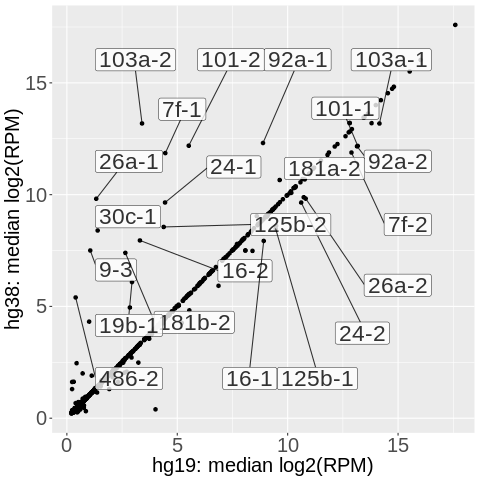

In [20]:
%%R -i qr1

plotDF <- qr1

## define outliers
plotDF$outlier <- ifelse ( (abs(plotDF$hg19_logMedian - plotDF$hg38_logMedian) >= 0.95) 
                         & (plotDF$hg38_logMedian >= 5.), 
                           "Off-diag", "On-diag" )

## abbreviate the miRNA names
plotDF$mirna_short <- substr ( plotDF$mirna_id, 9, 1000000L )
                          
## print ( head ( plotDF ) )

p1 <- ggplot ( data=plotDF, aes(x=hg19_logMedian, y=hg38_logMedian ) ) +
        geom_point() +
        labs ( x="hg19: median log2(RPM)", y="hg38: median log2(RPM)" ) +
        # theme_linedraw() +  
        theme_gray() +
        theme ( axis.title = element_text(size=20),
                axis.text  = element_text(size=20) ) +
        geom_label_repel (
          data = subset(plotDF, outlier=="Off-diag"),
          aes(label=mirna_short),
          size=8, alpha=0.8, 
          box.padding = unit(3, "lines"),
          point.padding = unit(0, "lines") )

print ( p1 )
ggsave ( "miRNA_panelC.pdf", plot=p1, device="pdf" )

The figure above shows the median expression levels for each miRNA stemloop, with the hg38-based quantification on the y-axis and the hg19-based quantification on the x-axis.  (Note that the labels have been truncated to avoid over-crowding in the image.  Each miRNA stemloop name starts with either `hsa-mir-` or `hsa-let-`.)

Notice how many of the labeled outliers come in pairs on either side of the y=x line, *eg* `16-1` and `16-2` or `92a-1` and `92a-2`.  If you need to locate and identify a specific miRNA, you can use the code in the next cell to print out the (x,y) coordinates (in the figure above) for any particular miRNA of interest.

In [21]:
id = 'hsa-mir-24-2'
print ( " %12s is at (x=%5.2f, y=%5.2f) " % ( id, qr1[ qr1['mirna_id']==id ]['hg19_logMedian'], qr1[ qr1['mirna_id']==id ]['hg38_logMedian'] ) )

id = 'hsa-mir-21'
print ( " %12s is at (x=%5.2f, y=%5.2f) " % ( id, qr1[ qr1['mirna_id']==id ]['hg19_logMedian'], qr1[ qr1['mirna_id']==id ]['hg38_logMedian'] ) )


 hsa-mir-24-2 is at (x=10.61, y= 9.65) 
   hsa-mir-21 is at (x=17.59, y=17.59) 


Below, we create a figure similar to the one above, but based on expression-levels for *mature* miRNAs (identified by `MIMAT` numbers).  (This figure was not included in the publication.)

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


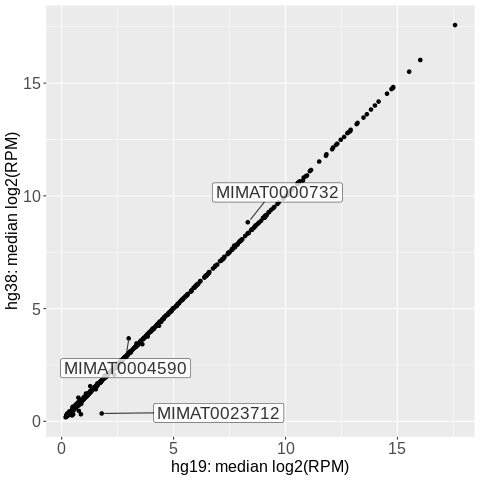

In [22]:
%%R -i qr2

plotDF <- qr2

plotDF$outlier <- ifelse ( (abs(plotDF$hg19_logMedian - plotDF$hg38_logMedian) >= 0.30 ) & 
                           ((plotDF$hg38_logMedian >= 1.) | (plotDF$hg19_logMedian >= 1.)), "Off-diag", "On-diag" )

p1 <- ggplot ( data=plotDF, aes(x=hg19_logMedian, y=hg38_logMedian ) ) +
        geom_point() +
        labs ( x="hg19: median log2(RPM)", y="hg38: median log2(RPM)" ) +
        theme_gray() +
        theme ( axis.title = element_text(size=16),
                axis.text  = element_text(size=16) ) +
        geom_label_repel ( 
          data = subset(plotDF, outlier=="Off-diag"),
          aes(label=mirna_accession),
          size=6, alpha=0.8, 
          box.padding = unit(1.0, "lines"),
          point.padding = unit(0.4, "lines") )
        
print ( p1 )

As is clear in the figure above, when we instead compute the median expression values for the mature miRNAs, there are very few outliers.

-  `MIMAT0000732` is the identifier for the mature sequence `hsa-miR-378a-3p`; it is the dominant mature sequence resulting from the `hsa-mir-378a` stemloop (`MI0000786`);
-  `MIMAT0004590` is the identifier for the mature sequence `hsa-miR-122-3p`; it is *not* the dominant mature sequence resulting from the `hsa-mir-122` stemloop (`MI0000442`); the dominant mature sequence is `hsa-miR-122-5p` (`MIMAT0000421`);
-  `MIMAT0023712` is the identifier for the mature sequence `hsa-miR-6087`   (NB: this sequence has been *removed* from miRBase release 22)

### Genome-wide Analyses

In this section, we will perform several genome-wide analyses.  Three different types of analyses are possible within this notebook:

-  **PanCancer**:  all of the available TCGA miRNA-seq data is analyzed jointly, disregarding tumor-types;
-  **All Tumor Types**:  all of the available TCGA miRNA-seq data is analyzed, but grouped according to tumor-type;
- **Single Tumor**: the analyses are restricted to a single tumor type, *eg* `BRCA`

First, we specify what type of analysis we want to do, using the `study` variable:

In [0]:
study = 'PanCancer'  
##study = 'All'       
##study = 'BRCA'       

Next, we use previously defined function to perform an analysis based on stemloop expression levels .  

(**Panel B** of the miRNA figure shows the stemloop correlation distribution with `study = 'PanCancer'`.)

In [24]:
qs3 = build_GWquery03 ( study )
qr3 = runQuery ( bqclient, qs3 )
if ( not checkQueryResults ( qr3 ) ):
  print ( " GW-Query #3 failed ?!?!? " )
  print ( qs3 )


 in runQuery ... 
    this query processed 2136762038 bytes 

 in checkQueryResults ... 
 # of rows in query results: 893 

          miRNA_ID      N   pearson  spearman
0    hsa-mir-1306  10769  0.998490  0.997977
1  hsa-mir-181a-2  10769  0.899910  0.899590
2    hsa-mir-2277  10769  0.989823  0.987449
3     hsa-mir-30e  10769  0.999754  0.999730
4     hsa-mir-410  10769  0.998847  0.998273


In the next cell, we switch to R (using the `%%R` cell magic) for the plotting, passing in both the `study` variable and the returned data frame, `qr1`.

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


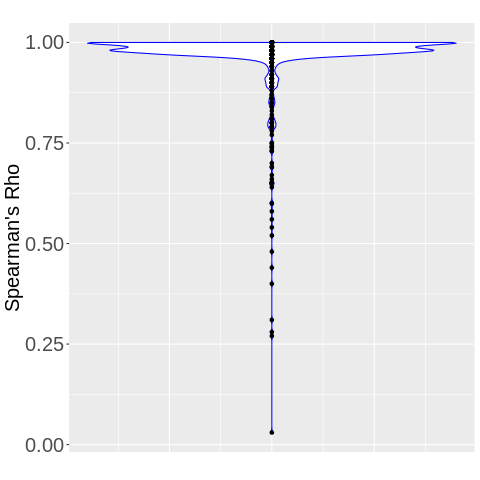

In [25]:
%%R -i study -i qr3

studyID = study
plotDF = qr3

if ( study != 'All' ) {
    
  p1 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(spearman)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        geom_point ( ) +
        labs ( x=" ", y="Spearman's Rho", title=" ", color=" ", size=" " ) +
        theme_gray() +
        theme ( axis.title  = element_text(size=20),
                axis.text   = element_text(size=20),
                axis.text.x = element_blank(),
                axis.ticks.x= element_blank() )

  # we could also generate a figure showing the distribution of Pearson
  # correlation coefficients
  p2 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(pearson)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        geom_point ( ) +
        labs ( x=" ", y="Pearson's Rho", title=" ", color=" ", size=" " ) +
        theme ( axis.text.x=element_blank(),
                axis.ticks.x=element_blank() )
    
  # grid.arrange ( p1, p2, nrow=1 )
  print ( p1 )
  ggsave ( "miRNA_panelB.pdf", plot=p1, device="pdf" )
    
} else {
    
  p3 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(spearman)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        facet_wrap ( ~Study, ncol=6 ) +
        labs ( x=" ", y="Spearman's Rho", title=" ", color=" ", size=" " ) +
        theme_linedraw() + 
        theme ( plot.title=element_text(size=14),
                axis.title=element_text(size=10),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank() )
    
  print (p3)
    
}
      


This next section performs the same type of analysis, but using the *mature* miRNA expression levels instead.  (This figure was not included in the publication.)

In [26]:
qs4 = build_GWquery04 ( study )
qr4 = runQuery ( bqclient, qs4 )
if ( not checkQueryResults ( qr4 ) ):
  print ( " GW-Query #4 failed ?!?!? " )
  print ( qs3 )


 in runQuery ... 
    this query processed 8850599149 bytes 

 in checkQueryResults ... 
 # of rows in query results: 1447 

   mirna_accession      N   pearson  spearman
0    MIMAT0000422   3122  0.999660  0.993709
1    MIMAT0000436   9837  0.998256  0.997455
2    MIMAT0000462   5948  0.999300  0.992541
3    MIMAT0000686  10233  0.999119  0.998201
4    MIMAT0000752  10769  0.999654  0.999588


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


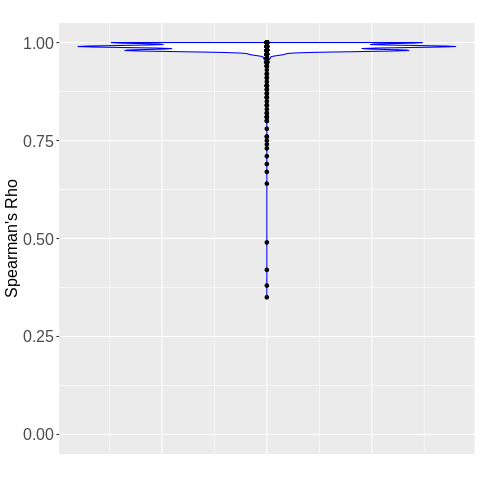

In [27]:
%%R -i study -i qr4

studyID = study
plotDF = qr4

if ( study != 'All' ) {

  p1 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(spearman)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        geom_point ( ) +
        coord_cartesian ( ylim=c(0,1) ) +
        labs ( x=" ", y="Spearman's Rho", title=" ", color=" ", size=" " ) +
        theme_gray() +
        theme ( axis.title  = element_text(size=16),
                axis.text   = element_text(size=16),
                axis.text.x = element_blank(),
                axis.ticks.x= element_blank() )

  p2 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(pearson)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        geom_point ( ) +
        coord_cartesian ( ylim=c(0,1) ) +
        labs ( x=" ", y="Pearson's Rho", title=" ", color=" ", size=" " ) +
        theme ( axis.text.x=element_blank(),
                axis.ticks.x=element_blank() )
    
  # grid.arrange ( p1, p2, nrow=1 )
  print ( p1 )
    
} else {
    
  p3 <- ggplot ( data=plotDF, aes(x=1,y=round(as.numeric(as.vector(spearman)), digits=2)) ) +
        geom_violin ( na.rm=TRUE, col="blue" ) +
        facet_wrap ( ~Study, ncol=6 ) +
        labs ( x=" ", y="Spearman's Rho", title=" ", color=" ", size=" " ) +
        theme_gray() +
        theme ( plot.title=element_text(size=14),
                axis.title=element_text(size=10),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank() )
    
  print (p3)
    
}

## miRNA-specific Analyses
Next, we will extract data for one or more specific miRNA's (*eg* `hsa-mir-24-2`) and one or more (or all) tumor types, and build the SQL strings for two miRNA-specific queries.



**NB** in the next cell, you can edit the `mirList` to include specific miRNA identifiers of interest.  (If you enter a string that is an invalid miRNA name, the query may fail.)  In addition, you can specify one or more specific tumor types to restrict the analysis to those specific tumor types, or leave the `tumorList` empty if you want data for *all* tumor types.

In [0]:
mirList = [ "hsa-mir-21", "hsa-mir-24-1", "hsa-mir-24-2" ]

tumorList = [ "TCGA-BLCA" ]
# tumorList = [ ]

Both miRNA-specific queries will be run in the next cell, and both sets of results passed to the subsequent R code-cell for plotting.  This section of the notebook can be used to reproduce **Panels D**, **E**, and **F** of the publication.  (In order to reproduce the publication panels, the tumorList should be empty, in order to use data from *all* tumor types.)

(Note that the second query will be run only if the first succeeds.)

In [39]:
qqs1 = build_miRquery01 ( mirList, tumorList )
qqr1 = runQuery ( bqclient, qqs1 )
if ( not checkQueryResults ( qqr1 ) ):
  print ( " miR-Query #1 failed ?!?!? " )
  print ( qqs1 )

else:
  qqs2 = build_miRquery02 ( mirList, tumorList )
  qqr2 = runQuery ( bqclient, qqs2 )
  if ( not checkQueryResults ( qqr2 ) ):
    print ( " miR-Query #2 failed ?!?!? " )
    print ( qqs2 )


 in runQuery ... 
    the results for this query were previously cached 

 in checkQueryResults ... 
 # of rows in query results: 1227 

                  AliquotBarcode      Study  ... BCR_protocol  BCGSC_platform
0  TCGA-XF-A9SW-01A-11R-A42V-13  TCGA-BLCA  ...  mirVana RNA           HiSeq
1  TCGA-ZF-A9RC-01A-11R-A38M-13  TCGA-BLCA  ...  mirVana RNA           HiSeq
2  TCGA-FD-A3B6-01A-21R-A20E-13  TCGA-BLCA  ...  mirVana RNA           HiSeq
3  TCGA-K4-A5RJ-01A-11R-A28I-13  TCGA-BLCA  ...  mirVana RNA           HiSeq
4  TCGA-4Z-AA87-01A-11R-A39B-13  TCGA-BLCA  ...  mirVana RNA           HiSeq

[5 rows x 8 columns]

 in runQuery ... 
    the results for this query were previously cached 

 in checkQueryResults ... 
 # of rows in query results: 3264 

                  AliquotBarcode      Study  ... BCR_protocol BCGSC_platform
0  TCGA-BT-A20Q-01A-11R-A14X-13  TCGA-BLCA  ...  mirVana RNA          HiSeq
1  TCGA-BT-A20Q-01A-11R-A14X-13  TCGA-BLCA  ...  mirVana RNA          HiSeq
2  TCGA-E7

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


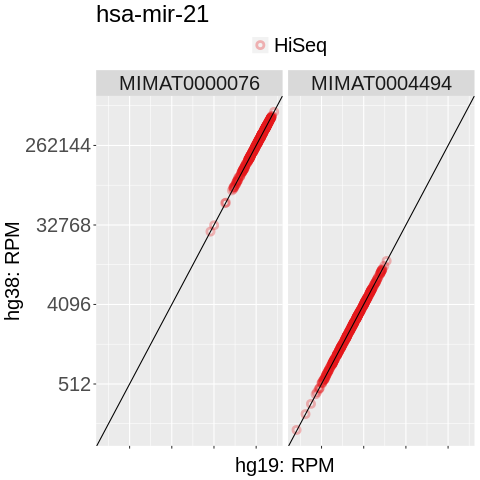

In [40]:
%%R  -i qqr1 -i qqr2 

## this cell can be used to re-create panels D, E, and F
## select the specific miRNA to be plotted ...

mirID = "hsa-mir-21"
#mirID = "hsa-mir-24-1"
#mirID = "hsa-mir-24-2"
plotFilePDF = ''

plotDF1 <- subset ( qqr1, mirnaID==mirID )
plotDF2 <- subset ( qqr2, mirnaID==mirID )

if ( (dim(plotDF1)[1] < 1) | (dim(plotDF2)[1] < 1) ) {
    
    print ( " No data to plot? ")
    
} else {

    colorByGroup = 'BCGSC_platform'
    plotDF1[,'colorByColumn'] = plotDF1[,colorByGroup]
    plotDF2[,'colorByColumn'] = plotDF2[,colorByGroup]

    spearman = cor(plotDF1$ds1_RPM,plotDF1$ds2_RPM,method="spearman")

    p1 <- ggplot ( data=plotDF1, aes(x=ds1_RPM,y=ds2_RPM,text=AliquotBarcode) ) +
            geom_point ( shape=21, stroke=2, size=2, alpha=0.3, aes(col=factor(colorByColumn)) ) +
            geom_abline ( slope=1, intercept=0, aes(size=2) ) +
            labs ( x="hg19: RPM", y="hg38: RPM",
                   title=mirID, color=" ", size=" " ) +
                  #title=paste ( mirID, " | rho = ", ifelse(is.numeric(spearman),round(spearman,4),"NA"), sep="" ),
            scale_x_continuous(trans='log2') +
            scale_y_continuous(trans='log2') +
            #xlim ( 0, 20 ) +
            #ylim ( 0, 20 ) +
            theme_gray() +
            theme ( plot.title =element_text(size=24),
                    axis.title =element_text(size=20),
                    axis.text.y=element_text(size=20),
                    axis.text.x=element_text(size= 0),
                    legend.text=element_text(size=20),
                    legend.position="top") +
            scale_colour_brewer ( palette="Set1" )

    p2 <- ggplot ( data=plotDF2, aes(x=ds1_RPM,y=ds2_RPM,text=AliquotBarcode) ) +
            geom_point ( shape=21, stroke=2, size=2, alpha=0.3, aes(col=factor(colorByColumn)) ) +
            geom_abline ( slope=1, intercept=0, aes(size=2) ) +
            facet_wrap ( ~mirna_accession, ncol=4 ) +
            labs ( x="hg19: RPM", y="hg38: RPM",
                   title=mirID, color=" ", size=" " ) +
            scale_x_continuous(trans='log2') +
            scale_y_continuous(trans='log2') +
            #xlim ( 0, 20 ) +
            #ylim ( 0, 20 ) +
            theme_gray() + 
            theme ( plot.title =element_text(size=24),
                    axis.title =element_text(size=20),
                    axis.text.y=element_text(size=20),
                    axis.text.x=element_text(size= 0),
                    legend.text=element_text(size=20),
                    strip.text =element_text(size=20),
                    legend.position="top") +
            scale_colour_brewer ( palette="Set1" )

    ## grid.arrange ( p1, p2, ncol=1 )
    ## print(p1)
    print(p2)
    
    if ( plotFilePDF != "" ) ggsave ( plotFilePDF, plot=p2, device="pdf" )
    
}

The final two sections of this notebook consist of highly-customized code to generate **Panels G**, and **H** from the publication.  They start from the dataframes returned from `miRquery01` and `miRquery02`.  Note that the figure panels mentioned contain 

[1] "Wilcoxon rank sum test for 5p strand (hg19 vs hg38):  0.984179807300374"
[1] "Wilcoxon rank sum test for 3p strand (hg19 vs hg38):  0.983707627431128"
[1] "Wilcoxon rank sum test for stem-loop (hg19 vs hg38):  0.986776891210125"


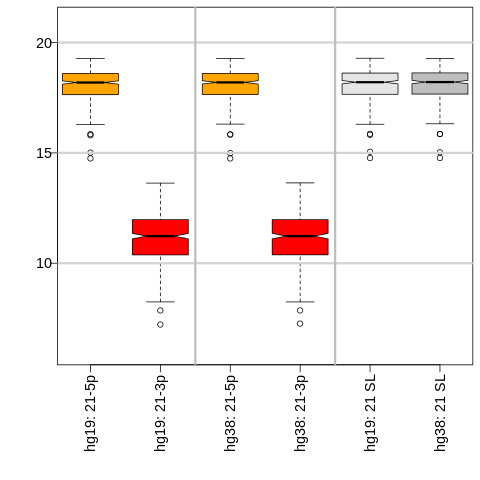

In [42]:
%%R -i qqr1 -i qqr2

## this panel can be used to re-create panel G

## the query results in qqr1 contain stem-loop expression levels
## and the query results in qqr2 contain mature miRNA expression levels

## the 'ds1' data column refers to hg19 data, and 'ds2' refers to hg38

## for panelG, we are focused just on mirnaID = 'hsa-mir-21'

#print ( head(qqr1) )
#print ( head(qqr2) )

mirID = 'hsa-mir-21'

## pull out the stemloop ('sl') subset for this specific mirID from qqr1
## and the mature ('mt') subset from qqr2:
slData <- subset ( qqr1, mirnaID==mirID )
mtData <- subset ( qqr2, mirnaID==mirID )

#print ( dim(slData) )

## then pull out the hg19 and hg38 data vectors:
hg19_sl <- log2 ( as.numeric ( slData$ds1_RPM ) )
hg38_sl <- log2 ( as.numeric ( slData$ds2_RPM ) )

## mtSymbols will be "hsa-miR-21-3p" and "hsa-miR-21-5p"
mtSymbols <- as.list(sort(unique(mtData[,"mirna_symbol"])))
#print ( mtSymbols )

## now subset out the 5p and 3p mature strand data, and then pull out
## the hg19 and hg38 data vectors for each:
mt5p <- subset ( mtData, mirna_symbol==mtSymbols[2] )
hg19_5p <- log2 ( as.numeric ( mt5p$ds1_RPM ) )
hg38_5p <- log2 ( as.numeric ( mt5p$ds2_RPM ) )

mt3p <- subset ( mtData, mirna_symbol==mtSymbols[1] )
hg19_3p <- log2 ( as.numeric ( mt3p$ds1_RPM ) )
hg38_3p <- log2 ( as.numeric ( mt3p$ds2_RPM ) )

w <- wilcox.test ( hg19_5p, hg38_5p )
print ( paste("Wilcoxon rank sum test for 5p strand (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_3p, hg38_3p ) 
print ( paste("Wilcoxon rank sum test for 3p strand (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_sl, hg38_sl ) 
print ( paste("Wilcoxon rank sum test for stem-loop (hg19 vs hg38): ", w$p.value) )

par ( mar=c(8,4,0.5,0.5), mgp=c(3,0.4,0), tck=-0.02 )
boxplot ( hg19_5p, hg19_3p, hg38_5p, hg38_3p, hg19_sl, hg38_sl,
          #log="y",
          xlim=c(0.75,6.25), ylim=c(6,21),
          col=c("orange","red","orange","red","grey90","grey"),
          names=c("hg19: 21-5p ", "hg19: 21-3p ", 
                  "hg38: 21-5p ", "hg38: 21-3p ", 
                  "hg19: 21 SL ", "hg38: 21 SL "),
          cex.axis=1.2, cex=1., 
          at=1:6, notch=T, las=2, varwidth=F
        )
grid ( nx=NA, ny=NULL, lty=1, lwd=3 )
lines(c(2.5,2.5), c(5,22), col = "grey", lwd = 3, lty = 1)
lines(c(4.5,4.5), c(5,22), col = "grey", lwd = 3, lty = 1)




[1] "Wilcoxon rank sum test for 24-1-5p strand (hg19 vs hg38):  0.675812513089515"
[1] "Wilcoxon rank sum test for 24-2-5p strand (hg19 vs hg38):  0.775867476523686"
[1] "Wilcoxon rank sum test for 24-3p   strand (hg19 vs hg38):  0.865338807797958"
[1] "Wilcoxon rank sum test for 24-1 stem loop (hg19 vs hg38):  2.83148876845695e-135"
[1] "Wilcoxon rank sum test for 24-2 stem loop (hg19 vs hg38):  4.69080647540664e-56"
[1] "Wilcoxon rank sum test for 24-1 and 24-2 stem loops (both hg38):  0.890073752276138"


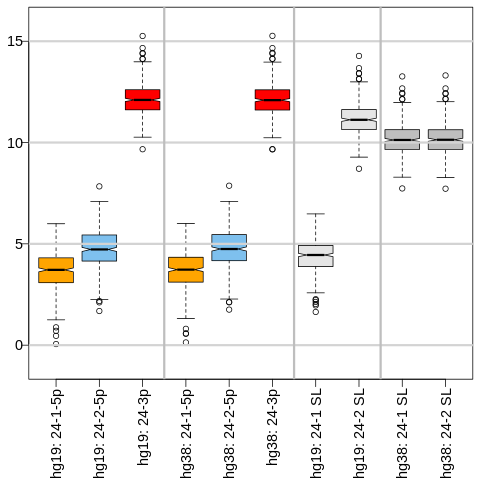

In [45]:
%%R -i qqr1 -i qqr2

## this panel can be used to re-create panel H

## the query results in qqr1 contain stem-loop expression levels
## and the query results in qqr2 contain mature miRNA expression levels

## the 'ds1' data column refers to hg19 data, and 'ds2' refers to hg38

## for panelG, we were focused just on mirnaID = 'hsa-mir-21'
## but for panelH, we are looking at hsa-mir-24-1 and hsa-mir-24-2:

#print ( head(qqr1) )
#print ( head(qqr2) )

mirID1 = 'hsa-mir-24-1'
mirID2 = 'hsa-mir-24-2'

## first, pull out the stemloop data for these two miRs, and then
## the hg19 and hg38 data vectors for each:
sl1Data <- subset ( qqr1, mirnaID==mirID1 )
sl2Data <- subset ( qqr1, mirnaID==mirID2 )

hg19_sl1 <- log2 ( as.numeric ( sl1Data$ds1_RPM ) )
hg38_sl1 <- log2 ( as.numeric ( sl1Data$ds2_RPM ) )

hg19_sl2 <- log2 ( as.numeric ( sl2Data$ds1_RPM ) )
hg38_sl2 <- log2 ( as.numeric ( sl2Data$ds2_RPM ) )

mtData <- subset ( qqr2, mirnaID==mirID1 | mirnaID==mirID2 ) 
mtSymbols <- as.list(sort(unique(mtData[,"mirna_symbol"])))

## the mtSymbols will be (in this order): 24-1-5p, 24-2-5p, and 24-3p
#print ( mtSymbols )

# since it is possible that different stemloop miRs produce the
# same mature miRNA, we need to group_by the AliquotBarcode and 
# then sum the RPM, after filtering for each mature miRNA

t <- subset ( mtData, mirna_symbol==mtSymbols[1]) %>% 
             group_by(AliquotBarcode) %>% 
             summarize(ds1_sum=sum(ds1_RPM),ds2_sum=sum(ds2_RPM) ) 

hg19_1_5p <- log2 ( as.numeric ( t$ds1_sum ) )
hg38_1_5p <- log2 ( as.numeric ( t$ds2_sum ) )

t <- subset ( mtData, mirna_symbol==mtSymbols[2]) %>% 
             group_by(AliquotBarcode) %>% 
             summarize(ds1_sum=sum(ds1_RPM),ds2_sum=sum(ds2_RPM) ) 

hg19_2_5p <- log2 ( as.numeric ( t$ds1_sum ) )
hg38_2_5p <- log2 ( as.numeric ( t$ds2_sum ) )

t <- subset ( mtData, mirna_symbol==mtSymbols[3]) %>% 
             group_by(AliquotBarcode) %>% 
             summarize(ds1_sum=sum(ds1_RPM),ds2_sum=sum(ds2_RPM) ) 

hg19_3p <- log2 ( as.numeric ( t$ds1_sum ) )
hg38_3p <- log2 ( as.numeric ( t$ds2_sum ) )

## perform Wilcoxon rank sum test between hg19 and hg38 data vectors:
w <- wilcox.test ( hg19_1_5p, hg38_1_5p )
print ( paste("Wilcoxon rank sum test for 24-1-5p strand (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_2_5p, hg38_2_5p )
print ( paste("Wilcoxon rank sum test for 24-2-5p strand (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_3p, hg38_3p )
print ( paste("Wilcoxon rank sum test for 24-3p   strand (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_sl1, hg38_sl1 )
print ( paste("Wilcoxon rank sum test for 24-1 stem loop (hg19 vs hg38): ", w$p.value) )
w <- wilcox.test ( hg19_sl2, hg38_sl2 )
print ( paste("Wilcoxon rank sum test for 24-2 stem loop (hg19 vs hg38): ", w$p.value) )

## one final Wilcoxon rank sum test between the hg38 24-1 and 24-2 stemloops:
w <- wilcox.test ( hg38_sl1, hg38_sl2 )
print ( paste("Wilcoxon rank sum test for 24-1 and 24-2 stem loops (both hg38): ", w$p.value) )

par ( mar=c(7,2,0.5,0.5), mgp=c(3,0.4,0), tck=-0.02 )
boxplot ( hg19_1_5p, hg19_2_5p, hg19_3p,
          hg38_1_5p, hg38_2_5p, hg38_3p,
          hg19_sl1,  hg19_sl2, hg38_sl1, hg38_sl2,
          xlim=c(0.75,10.25), ylim=c(-1,16),
          col=c("orange", "skyblue2", "red",  
                "orange", "skyblue2", "red", 
                "grey90","grey90", "grey", "grey"),
          names=c("hg19: 24-1-5p ", "hg19: 24-2-5p ", "hg19: 24-3p ", 
                  "hg38: 24-1-5p ", "hg38: 24-2-5p ", "hg38: 24-3p ", 
                  "hg19: 24-1 SL ", "hg19: 24-2 SL ", 
                  "hg38: 24-1 SL ", "hg38: 24-2 SL "),
          cex.axis=1.2, cex=1., at=1:10, 
          notch=T, las=2, varwidth=F
        )
grid ( nx=NA, ny=NULL, lty=1, lwd=3 )
lines(c(3.5,3.5), c(-2,17), col = "grey", lwd = 3, lty = 1)
lines(c(6.5,6.5), c(-2,17), col = "grey", lwd = 3, lty = 1)
lines(c(8.5,8.5), c(-2,17), col = "grey", lwd = 3, lty = 1)


In [0]:
## if any PDF files have been generated, gc.files.download() 
## can be used to download them to your local machine

if ( 0 ):
    gc.files.download ( "miRNA_panel.pdf" )
